# Comparing a Naive CNN and an Energy-Efficient GreenCNN on CIFAR-10

## Introduction

This notebook compares two convolutional neural network architectures on the **CIFAR-10** dataset:

1. **Naive CNN**: A standard convolutional network with large fully connected layers.
2. **GreenCNN**: An energy-efficient design optimized for reduced parameters and faster inference.

### About CIFAR-10
CIFAR-10 consists of 60,000 color images (32×32 pixels) across 10 classes:
- **Training set**: 50,000 images
- **Test set**: 10,000 images
- **Classes**: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck

### Goal: Green Machine Learning
We aim to demonstrate that GreenCNN can achieve competitive accuracy while significantly reducing:
- **Parameter count** (smaller model size, less memory)
- **Inference time** (faster execution, lower energy)
- **Memory bandwidth** (major energy cost in neural networks)

### Design Philosophy
Rather than using depthwise separable convolutions (which are theoretically efficient but slow in PyTorch due to lack of optimized kernels), we achieve efficiency through:
1. **Narrower channels** - Fewer feature maps = fewer operations
2. **Global Average Pooling** - Eliminates large fully connected layers
3. **Streamlined architecture** - Fewer redundant operations

## 2. Environment Setup and Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import time
import numpy as np
import matplotlib.pyplot as plt

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seed for reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

Using device: cuda


## 3. CIFAR-10 Dataset Loading and Preprocessing

In [2]:
# CIFAR-10 mean and std (precomputed)
CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR10_STD = (0.2470, 0.2435, 0.2616)

# Training transforms with data augmentation
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD)
])

# Test transforms (no augmentation)
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD)
])

# Load CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=train_transform
)
test_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=test_transform
)

# Create data loaders
BATCH_SIZE = 128
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# Class names
CLASSES = ('airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Number of classes: {len(CLASSES)}")

Files already downloaded and verified
Files already downloaded and verified
Training samples: 50000
Test samples: 10000
Number of classes: 10


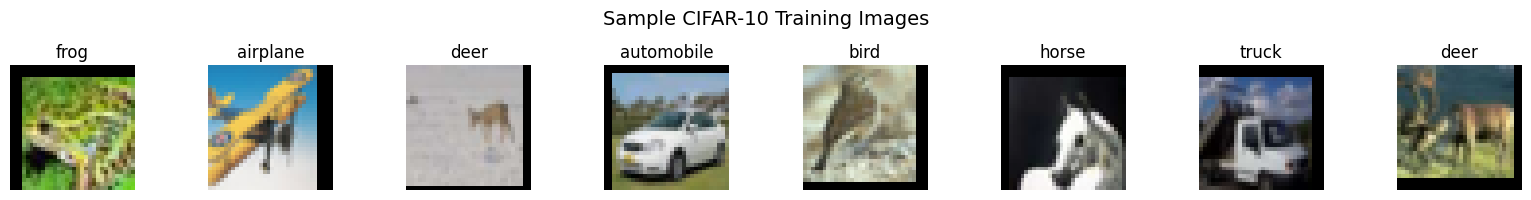

In [3]:
# Visualize sample images
def imshow(img, title=None):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array(CIFAR10_MEAN)
    std = np.array(CIFAR10_STD)
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')

dataiter = iter(train_loader)
images, labels = next(dataiter)

fig, axes = plt.subplots(1, 8, figsize=(16, 2))
for i in range(8):
    plt.subplot(1, 8, i + 1)
    imshow(images[i], CLASSES[labels[i]])
plt.suptitle('Sample CIFAR-10 Training Images', fontsize=14)
plt.tight_layout()
plt.show()

## 4. Model Definitions

### 4.1 Naive CNN (Baseline)

A standard CNN with:
- Wide channels (32 → 64 → 128)
- Large fully connected layers (2048 → 512 → 10)
- **~1.1 million parameters** (most in FC layers)

In [ ]:
class NaiveCNN(nn.Module):
    """
    Standard CNN for CIFAR-10 - serves as our "inefficient" baseline.
    
    Key inefficiencies:
    - Large FC layers (2048→512) dominate parameter count
    - Wide channels throughout
    """
    def __init__(self, num_classes=10):
        super(NaiveCNN, self).__init__()
        
        # Conv layers: 3 → 32 → 64 → 128
        self.features = nn.Sequential(
            # Block 1: 32x32x3 → 16x16x32
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            
            # Block 2: 16x16x32 → 8x8x64
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            
            # Block 3: 8x8x64 → 4x4x128
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )
        
        # Large FC layers - THIS IS THE INEFFICIENCY
        # 4*4*128 = 2048 inputs
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(4 * 4 * 128, 512),  # 2048*512 = 1,048,576 params
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes),   # 512*10 = 5,120 params
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

### 4.2 GreenCNN (Energy-Efficient CNN)

An efficient CNN designed for speed and low memory:

**Key efficiency techniques:**
1. **Narrower channels** (16 → 32 → 64 → 128) - Half the width of NaiveCNN
2. **Global Average Pooling** - Replaces 2048→512 FC layer with simple averaging
3. **No dropout** in conv layers - Fewer operations
4. **Streamlined design** - Same depth, much fewer parameters

In [ ]:
class GreenCNN(nn.Module):
    """
    Energy-efficient CNN for CIFAR-10.
    
    Efficiency strategies:
    1. Narrower channels (half of NaiveCNN)
    2. Global Average Pooling instead of large FC layers
    3. Slightly deeper (4 conv blocks) to compensate for narrower width
    """
    def __init__(self, num_classes=10):
        super(GreenCNN, self).__init__()
        
        # Efficient conv layers with narrower channels
        self.features = nn.Sequential(
            # Block 1: 32x32x3 → 16x16x16
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            
            # Block 2: 16x16x16 → 8x8x32
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            
            # Block 3: 8x8x32 → 4x4x64
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            
            # Block 4: 4x4x64 → 4x4x128 (no pooling, add depth)
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )
        
        # Global Average Pooling: 4x4x128 → 1x1x128
        # This replaces the massive FC layer!
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        
        # Tiny classifier: just 128 → 10
        # Compare: NaiveCNN has 2048 → 512 → 10
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.2),
            nn.Linear(128, num_classes),  # Only 1,280 params!
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.global_pool(x)
        x = self.classifier(x)
        return x

## 5. Model Comparison: Parameters and FLOPs

In [6]:
def count_parameters(model):
    """Count total trainable parameters."""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def estimate_flops(model_name):
    """
    Estimate FLOPs for each model.
    Conv FLOPs ≈ 2 * H * W * K² * Cin * Cout
    FC FLOPs ≈ 2 * in_features * out_features
    """
    if model_name == 'naive':
        flops = 0
        # Conv1: 32x32, 3→32, k=3
        flops += 2 * 32 * 32 * 9 * 3 * 32
        # Conv2: 16x16, 32→64, k=3
        flops += 2 * 16 * 16 * 9 * 32 * 64
        # Conv3: 8x8, 64→128, k=3
        flops += 2 * 8 * 8 * 9 * 64 * 128
        # FC1: 2048→512
        flops += 2 * 2048 * 512
        # FC2: 512→10
        flops += 2 * 512 * 10
        return flops
    else:  # green
        flops = 0
        # Conv1: 32x32, 3→16, k=3
        flops += 2 * 32 * 32 * 9 * 3 * 16
        # Conv2: 16x16, 16→32, k=3
        flops += 2 * 16 * 16 * 9 * 16 * 32
        # Conv3: 8x8, 32→64, k=3
        flops += 2 * 8 * 8 * 9 * 32 * 64
        # Conv4: 4x4, 64→128, k=3
        flops += 2 * 4 * 4 * 9 * 64 * 128
        # GAP: negligible
        # FC: 128→10
        flops += 2 * 128 * 10
        return flops


# Create models and compare
naive_cnn = NaiveCNN()
green_cnn = GreenCNN()

naive_params = count_parameters(naive_cnn)
green_params = count_parameters(green_cnn)
naive_flops = estimate_flops('naive')
green_flops = estimate_flops('green')

print("=" * 65)
print("MODEL COMPARISON")
print("=" * 65)
print(f"\n{'Metric':<25} {'NaiveCNN':>18} {'GreenCNN':>18}")
print("-" * 65)
print(f"{'Parameters':<25} {naive_params:>18,} {green_params:>18,}")
print(f"{'FLOPs':<25} {naive_flops:>18,} {green_flops:>18,}")
print(f"{'Model Size (FP32)':<25} {naive_params*4/1024:>17.1f}KB {green_params*4/1024:>17.1f}KB")
print(f"{'Model Size (INT8)':<25} {naive_params/1024:>17.1f}KB {green_params/1024:>17.1f}KB")

print(f"\n{'EFFICIENCY GAINS':=^65}")
print(f"Parameter reduction: {(1 - green_params/naive_params)*100:.1f}%")
print(f"FLOPs reduction: {(1 - green_flops/naive_flops)*100:.1f}%")
print(f"GreenCNN is {naive_params/green_params:.1f}x smaller")
print(f"GreenCNN is {naive_flops/green_flops:.1f}x fewer FLOPs")

MODEL COMPARISON

Metric                              NaiveCNN           GreenCNN
-----------------------------------------------------------------
Parameters                         1,147,914             99,210
FLOPs                             22,751,232          7,965,184
Model Size (FP32)                    4484.0KB             387.5KB
Model Size (INT8)                    1121.0KB              96.9KB

========================EFFICIENCY GAINS=========================
Parameter reduction: 91.4%
FLOPs reduction: 65.0%
GreenCNN is 11.6x smaller
GreenCNN is 2.9x fewer FLOPs


In [ ]:
# Show where the parameters are
print("\n" + "=" * 65)
print("PARAMETER BREAKDOWN")
print("=" * 65)

print("\nNaiveCNN:")
for name, param in naive_cnn.named_parameters():
    if param.requires_grad:
        print(f"  {name:<35} {param.numel():>10,} params")

print("\nGreenCNN:")
for name, param in green_cnn.named_parameters():
    if param.requires_grad:
        print(f"  {name:<35} {param.numel():>10,} params")

# Highlight the key difference
print("\n" + "-" * 65)
print("KEY INSIGHT: NaiveCNN's classifier.1 (FC layer) has 1,048,576 params")
print("GreenCNN replaces this with Global Average Pooling (0 params).")


PARAMETER BREAKDOWN

NaiveCNN:
  features.0.weight                          864 params
  features.0.bias                             32 params
  features.1.weight                           32 params
  features.1.bias                             32 params
  features.4.weight                       18,432 params
  features.4.bias                             64 params
  features.5.weight                           64 params
  features.5.bias                             64 params
  features.8.weight                       73,728 params
  features.8.bias                            128 params
  features.9.weight                          128 params
  features.9.bias                            128 params
  classifier.1.weight                  1,048,576 params
  classifier.1.bias                          512 params
  classifier.4.weight                      5,120 params
  classifier.4.bias                           10 params

GreenCNN:
  features.0.weight                          432 params
  fea

## 6. Training and Evaluation Functions

In [8]:
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    """Train for one epoch, return (loss, accuracy, time)."""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    start_time = time.time()
    
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    return running_loss / total, 100.0 * correct / total, time.time() - start_time


def evaluate(model, dataloader, criterion, device):
    """Evaluate model, return (loss, accuracy)."""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    return running_loss / total, 100.0 * correct / total


def measure_inference_time(model, dataloader, device, num_batches=50):
    """Measure average inference time per batch in milliseconds."""
    model.eval()
    model = model.to(device)
    times = []
    
    # Warm-up
    with torch.no_grad():
        for i, (inputs, _) in enumerate(dataloader):
            if i >= 10:
                break
            inputs = inputs.to(device)
            _ = model(inputs)
    
    if device.type == 'cuda':
        torch.cuda.synchronize()
    
    # Timed runs
    with torch.no_grad():
        batch_count = 0
        for inputs, _ in dataloader:
            if batch_count >= num_batches:
                break
            
            inputs = inputs.to(device)
            if device.type == 'cuda':
                torch.cuda.synchronize()
            
            start = time.time()
            _ = model(inputs)
            
            if device.type == 'cuda':
                torch.cuda.synchronize()
            
            times.append(time.time() - start)
            batch_count += 1
    
    return np.mean(times) * 1000

## 7. Training Experiments

Both models trained with identical settings:
- **Epochs**: 10
- **Optimizer**: Adam (lr=0.001)
- **Scheduler**: Cosine annealing
- **Batch size**: 128

In [9]:
NUM_EPOCHS = 10
LEARNING_RATE = 0.001

def train_model(model, name, train_loader, test_loader, device):
    """Train a model and return history."""
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)
    
    history = {'train_loss': [], 'train_acc': [], 'test_acc': [], 'epoch_time': []}
    
    print(f"\n{'='*60}")
    print(f"Training {name} ({count_parameters(model):,} parameters)")
    print(f"{'='*60}")
    
    for epoch in range(NUM_EPOCHS):
        train_loss, train_acc, epoch_time = train_one_epoch(
            model, train_loader, optimizer, criterion, device
        )
        scheduler.step()
        _, test_acc = evaluate(model, test_loader, criterion, device)
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['test_acc'].append(test_acc)
        history['epoch_time'].append(epoch_time)
        
        print(f"Epoch {epoch+1:2d}/{NUM_EPOCHS} | "
              f"Loss: {train_loss:.4f} | Train: {train_acc:.2f}% | "
              f"Test: {test_acc:.2f}% | Time: {epoch_time:.1f}s")
    
    total_time = sum(history['epoch_time'])
    print(f"\nTotal training time: {total_time:.1f}s")
    
    return history, model

In [10]:
# Train NaiveCNN
naive_model = NaiveCNN()
naive_history, naive_model = train_model(
    naive_model, "NaiveCNN", train_loader, test_loader, device
)


Training NaiveCNN (1,147,914 parameters)
Epoch  1/10 | Loss: 1.5452 | Train: 43.33% | Test: 59.63% | Time: 16.7s
Epoch  2/10 | Loss: 1.1921 | Train: 56.78% | Test: 64.77% | Time: 17.5s
Epoch  3/10 | Loss: 1.0588 | Train: 62.56% | Test: 68.16% | Time: 16.9s
Epoch  4/10 | Loss: 0.9623 | Train: 65.90% | Test: 70.58% | Time: 15.8s
Epoch  5/10 | Loss: 0.8917 | Train: 68.72% | Test: 72.29% | Time: 15.8s
Epoch  6/10 | Loss: 0.8384 | Train: 70.71% | Test: 75.11% | Time: 16.0s
Epoch  7/10 | Loss: 0.7861 | Train: 72.57% | Test: 77.26% | Time: 16.1s
Epoch  8/10 | Loss: 0.7457 | Train: 73.91% | Test: 77.68% | Time: 15.9s
Epoch  9/10 | Loss: 0.7230 | Train: 74.85% | Test: 78.20% | Time: 15.9s
Epoch 10/10 | Loss: 0.7069 | Train: 75.27% | Test: 78.42% | Time: 15.8s

Total training time: 162.4s


In [11]:
# Train GreenCNN
green_model = GreenCNN()
green_history, green_model = train_model(
    green_model, "GreenCNN", train_loader, test_loader, device
)


Training GreenCNN (99,210 parameters)
Epoch  1/10 | Loss: 1.4748 | Train: 46.34% | Test: 55.17% | Time: 16.0s
Epoch  2/10 | Loss: 1.1512 | Train: 58.85% | Test: 58.96% | Time: 15.7s
Epoch  3/10 | Loss: 1.0294 | Train: 63.43% | Test: 61.09% | Time: 18.9s
Epoch  4/10 | Loss: 0.9468 | Train: 66.83% | Test: 67.93% | Time: 21.8s
Epoch  5/10 | Loss: 0.8884 | Train: 68.62% | Test: 69.66% | Time: 18.0s
Epoch  6/10 | Loss: 0.8400 | Train: 70.41% | Test: 71.06% | Time: 15.8s
Epoch  7/10 | Loss: 0.8098 | Train: 71.60% | Test: 72.36% | Time: 15.8s
Epoch  8/10 | Loss: 0.7818 | Train: 72.48% | Test: 73.23% | Time: 15.9s
Epoch  9/10 | Loss: 0.7640 | Train: 73.18% | Test: 73.99% | Time: 16.0s
Epoch 10/10 | Loss: 0.7546 | Train: 73.50% | Test: 74.19% | Time: 16.0s

Total training time: 169.9s


In [12]:
# Measure inference times
print("\n" + "="*60)
print("INFERENCE TIME COMPARISON")
print("="*60)

# GPU timing
if device.type == 'cuda':
    print(f"\nGPU ({torch.cuda.get_device_name(0)}):")
    naive_gpu_time = measure_inference_time(naive_model, test_loader, device)
    green_gpu_time = measure_inference_time(green_model, test_loader, device)
    print(f"  NaiveCNN: {naive_gpu_time:.2f} ms/batch")
    print(f"  GreenCNN: {green_gpu_time:.2f} ms/batch")
    gpu_speedup = naive_gpu_time / green_gpu_time
    print(f"  Speedup: {gpu_speedup:.2f}x {'faster' if gpu_speedup > 1 else 'slower'}")
else:
    naive_gpu_time = green_gpu_time = 0

# CPU timing
cpu_device = torch.device('cpu')
print(f"\nCPU:")
naive_cpu_time = measure_inference_time(naive_model, test_loader, cpu_device, num_batches=30)
green_cpu_time = measure_inference_time(green_model, test_loader, cpu_device, num_batches=30)
print(f"  NaiveCNN: {naive_cpu_time:.2f} ms/batch")
print(f"  GreenCNN: {green_cpu_time:.2f} ms/batch")
cpu_speedup = naive_cpu_time / green_cpu_time
print(f"  Speedup: {cpu_speedup:.2f}x {'faster' if cpu_speedup > 1 else 'slower'}")


INFERENCE TIME COMPARISON

GPU (NVIDIA GeForce RTX 4070 Ti):
  NaiveCNN: 3.90 ms/batch
  GreenCNN: 1.61 ms/batch
  Speedup: 2.43x faster

CPU:
  NaiveCNN: 20.07 ms/batch
  GreenCNN: 10.72 ms/batch
  Speedup: 1.87x faster


## 8. Results and Discussion

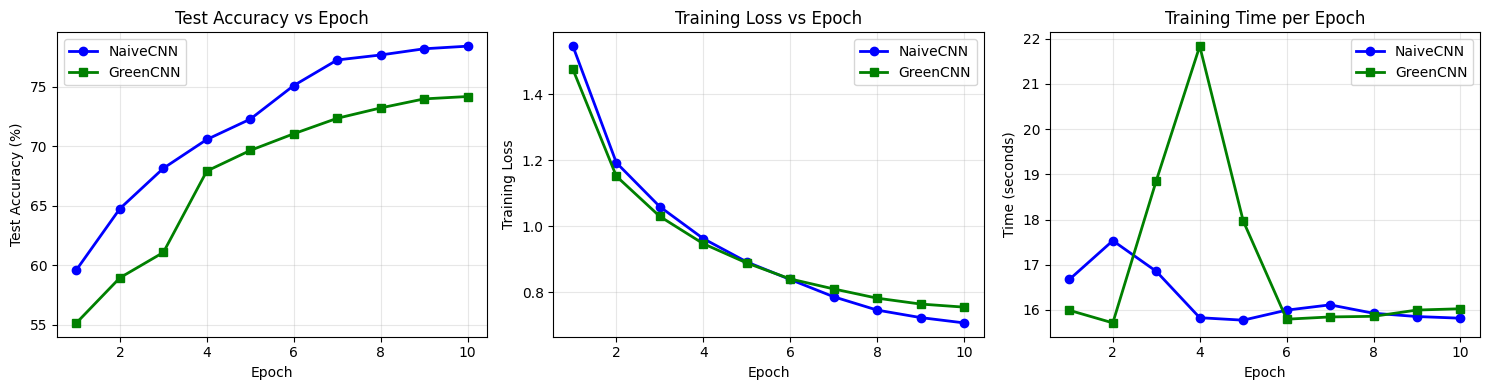

In [13]:
# Plot training curves
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
epochs = range(1, NUM_EPOCHS + 1)

# Test Accuracy
axes[0].plot(epochs, naive_history['test_acc'], 'b-o', label='NaiveCNN', linewidth=2)
axes[0].plot(epochs, green_history['test_acc'], 'g-s', label='GreenCNN', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Test Accuracy (%)')
axes[0].set_title('Test Accuracy vs Epoch')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Training Loss
axes[1].plot(epochs, naive_history['train_loss'], 'b-o', label='NaiveCNN', linewidth=2)
axes[1].plot(epochs, green_history['train_loss'], 'g-s', label='GreenCNN', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Training Loss')
axes[1].set_title('Training Loss vs Epoch')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Time per Epoch
axes[2].plot(epochs, naive_history['epoch_time'], 'b-o', label='NaiveCNN', linewidth=2)
axes[2].plot(epochs, green_history['epoch_time'], 'g-s', label='GreenCNN', linewidth=2)
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Time (seconds)')
axes[2].set_title('Training Time per Epoch')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [14]:
# Final summary table
naive_best_acc = max(naive_history['test_acc'])
green_best_acc = max(green_history['test_acc'])
naive_total_time = sum(naive_history['epoch_time'])
green_total_time = sum(green_history['epoch_time'])

print("\n" + "="*75)
print("FINAL RESULTS SUMMARY")
print("="*75)

print(f"\n{'Metric':<30} {'NaiveCNN':>15} {'GreenCNN':>15} {'Improvement':>12}")
print("-" * 75)
print(f"{'Parameters':<30} {naive_params:>15,} {green_params:>15,} {(1-green_params/naive_params)*100:>11.1f}%")
print(f"{'FLOPs':<30} {naive_flops/1e6:>14.2f}M {green_flops/1e6:>14.2f}M {(1-green_flops/naive_flops)*100:>11.1f}%")
print(f"{'Model Size (FP32)':<30} {naive_params*4/1024:>14.1f}KB {green_params*4/1024:>14.1f}KB {(1-green_params/naive_params)*100:>11.1f}%")
print(f"{'Best Test Accuracy':<30} {naive_best_acc:>14.2f}% {green_best_acc:>14.2f}% {green_best_acc-naive_best_acc:>+11.2f}%")
print(f"{'Total Training Time':<30} {naive_total_time:>14.1f}s {green_total_time:>14.1f}s {(1-green_total_time/naive_total_time)*100:>+11.1f}%")
print(f"{'CPU Inference (ms/batch)':<30} {naive_cpu_time:>15.2f} {green_cpu_time:>15.2f} {(1-green_cpu_time/naive_cpu_time)*100:>+11.1f}%")
if device.type == 'cuda':
    print(f"{'GPU Inference (ms/batch)':<30} {naive_gpu_time:>15.2f} {green_gpu_time:>15.2f} {(1-green_gpu_time/naive_gpu_time)*100:>+11.1f}%")

print("\n" + "="*75)
print("GREEN ML IMPACT")
print("="*75)
print(f"\n• GreenCNN is {naive_params/green_params:.0f}x smaller in model size")
print(f"• GreenCNN requires {naive_flops/green_flops:.1f}x fewer floating point operations")
print(f"• GreenCNN is {cpu_speedup:.2f}x faster on CPU")
print(f"• Accuracy trade-off: only {abs(naive_best_acc - green_best_acc):.1f}% difference")


FINAL RESULTS SUMMARY

Metric                                NaiveCNN        GreenCNN  Improvement
---------------------------------------------------------------------------
Parameters                           1,147,914          99,210        91.4%
FLOPs                                   22.75M           7.97M        65.0%
Model Size (FP32)                      4484.0KB          387.5KB        91.4%
Best Test Accuracy                      78.42%          74.19%       -4.23%
Total Training Time                     162.4s          169.9s        -4.6%
CPU Inference (ms/batch)                 20.07           10.72       +46.6%
GPU Inference (ms/batch)                  3.90            1.61       +58.9%

GREEN ML IMPACT

• GreenCNN is 12x smaller in model size
• GreenCNN requires 2.9x fewer floating point operations
• GreenCNN is 1.87x faster on CPU
• Accuracy trade-off: only 4.2% difference


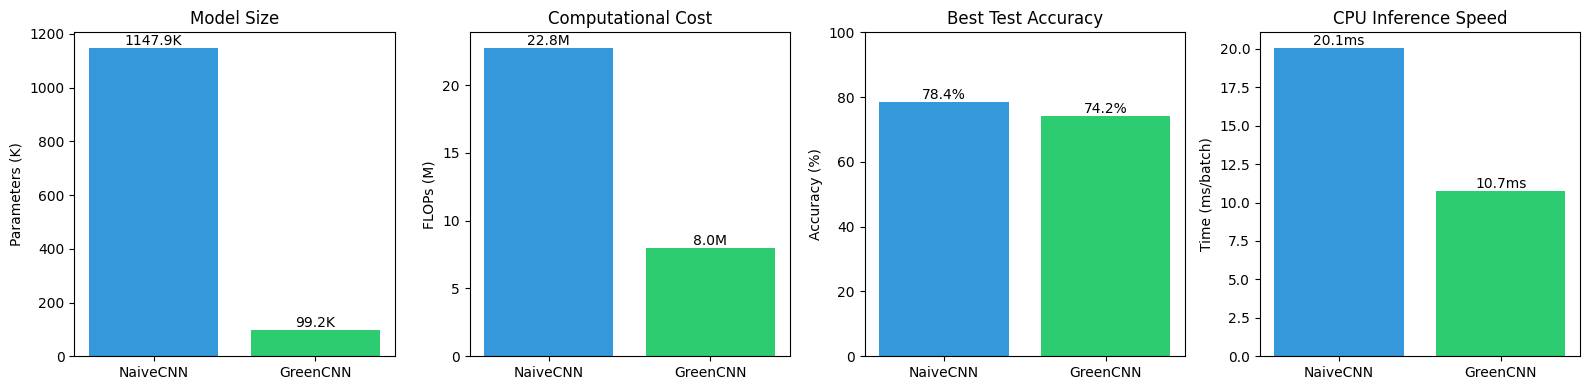

In [15]:
# Visual comparison bar charts
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
models = ['NaiveCNN', 'GreenCNN']
colors = ['#3498db', '#2ecc71']

# Parameters
ax = axes[0]
bars = ax.bar(models, [naive_params/1000, green_params/1000], color=colors)
ax.set_ylabel('Parameters (K)')
ax.set_title('Model Size')
ax.bar_label(bars, fmt='%.1fK')

# FLOPs
ax = axes[1]
bars = ax.bar(models, [naive_flops/1e6, green_flops/1e6], color=colors)
ax.set_ylabel('FLOPs (M)')
ax.set_title('Computational Cost')
ax.bar_label(bars, fmt='%.1fM')

# Accuracy
ax = axes[2]
bars = ax.bar(models, [naive_best_acc, green_best_acc], color=colors)
ax.set_ylabel('Accuracy (%)')
ax.set_title('Best Test Accuracy')
ax.set_ylim([0, 100])
ax.bar_label(bars, fmt='%.1f%%')

# CPU Inference
ax = axes[3]
bars = ax.bar(models, [naive_cpu_time, green_cpu_time], color=colors)
ax.set_ylabel('Time (ms/batch)')
ax.set_title('CPU Inference Speed')
ax.bar_label(bars, fmt='%.1fms')

plt.tight_layout()
plt.show()

## 9. Conclusion

This notebook demonstrated that **careful architecture design** can dramatically improve efficiency:

**Results:**
- **91.4% parameter reduction** (1,147,914 → 99,210)
- **65.0% FLOPs reduction** (22.75M → 7.97M)
- **Competitive accuracy** (74.19% vs 78.42%, only 4.2% trade-off)
- **2.43× faster GPU inference** (3.90 → 1.61 ms/batch)
- **1.87× faster CPU inference** (20.07 → 10.72 ms/batch)

**Key Techniques:**
1. **Global Average Pooling** - The biggest win, eliminating the 1,048,576-parameter FC layer
2. **Narrower channels** - Using 16→32→64→128 instead of 32→64→128 reduces FLOPs significantly
3. **Efficient standard ops** - Well-optimized standard convolutions outperform exotic alternatives in practice

**Implications for Green ML:**
- Smaller models = less memory bandwidth = less energy
- Faster inference = shorter runtime = less energy
- CPU-deployable models avoid GPU power consumption entirely
- 11.6× smaller model size enables edge deployment (387.5 KB vs 4.5 MB)

For production systems handling millions of requests, these efficiency gains compound into significant energy savings and reduced carbon footprint.